# Домашнее задание. Нейросетевая классификация текстов

В этом домашнем задании вам предстоит самостоятельно решить задачу классификации текстов на основе семинарского кода. Мы будем использовать датасет [ag_news](https://paperswithcode.com/dataset/ag-news). Это датасет для классификации новостей на 4 темы: "World", "Sports", "Business", "Sci/Tech".

Установим модуль datasets, чтобы нам проще было работать с данными.

In [ ]:
!pip install datasets

Импорт необходимых библиотек

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

import seaborn
seaborn.set(palette='summer')
import pandas as pd

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных
Для вашего удобства, мы привели код обработки датасета в ноутбуке. Ваша задача --- обучить модель, которая получит максимальное возможное качество на тестовой части.

In [ ]:
# Загрузим датасет
dataset = datasets.load_dataset('ag_news')

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Dataset ag_news downloaded and prepared to /root/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Как и в семинаре, выполним следующие шаги:
* Составим словарь
* Создадим класс WordDataset
* Выделим обучающую и тестовую часть, создадим DataLoader-ы.

In [ ]:
words = Counter()

for example in tqdm(dataset['train']['text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))

    for word in word_tokenize(prccessed_text):
        words[word] += 1


# vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
vocab = list(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 25

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

  0%|          | 0/120000 [00:00<?, ?it/s]

Размер словаря: 11842


In [ ]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ]
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])

    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

In [ ]:
def seed_torch(seed):
 random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

In [ ]:
seed_torch(42)

In [ ]:
train_dataset = WordDataset(dataset['train'])

# np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 5000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 32
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Постановка задачи
Ваша задача -- получить максимальное возможное accuracy на `eval_dataloader`. Ниже приведена функция, которую вам необходимо запустить для обученной модели, чтобы вычислить качество её работы.

In [ ]:
def evaluate(model, eval_dataloader) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

## Ход работы
Оценка за домашнее задание складывается из четырех частей:
### Запуск базовой модели с семинара на новом датасете (1 балл)
На семинаре мы создали модель, которая дает на нашей задаче довольно высокое качество. Ваша цель --- обучить ее и вычислить `score`, который затем можно будет использовать в качестве бейзлайна.

В модели появится одно важное изменение: количество классов теперь равно не 2, а 4. Обратите на это внимание и найдите, что в коде создания модели нужно модифицировать, чтобы учесть это различие.

### Проведение экспериментов по улучшению модели (2 балла за каждый эксперимент)
Чтобы улучшить качество базовой модели, можно попробовать различные идеи экспериментов. Каждый выполненный эксперимент будет оцениваться в 2 балла. Для получения полного балла за этот пункт вам необходимо выполнить по крайней мере 2 эксперимента. Не расстраивайтесь, если какой-то эксперимент не дал вам прироста к качеству: он все равно зачтется, если выполнен корректно.

Вот несколько идей экспериментов:
* **Модель RNN**. Попробуйте другие нейросетевые модели --- LSTM и GRU. Мы советуем обратить внимание на [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html), так как интерфейс этого класса ничем не отличается от обычной Vanilla RNN, которую мы использовали на семинаре.
* **Увеличение количества рекуррентных слоев модели**. Это можно сделать с помощью параметра `num_layers` в классе `nn.RNN`. В такой модели выходы первой RNN передаются в качестве входов второй RNN и так далее.
* **Изменение архитектуры после применения RNN**. В базовой модели используется агрегация со всех эмбеддингов. Возможно, вы захотите конкатенировать результат агрегации и эмбеддинг с последнего токена.
* **Подбор гиперпараметров и обучение до сходимости**. Возможно, для получения более высокого качества просто необходимо увеличить количество эпох обучения нейросети, а также попробовать различные гиперпараметры: размер словаря, `dropout_rate`, `hidden_dim`.

Обратите внимание, что главное правило проведения экспериментов --- необходимо совершать одно архитектурное изменение в одном эксперименте. Если вы совершите несколько изменений, то будет неясно, какое именно из изменений дало прирост к качеству.

### Получение высокого качества (3 балла)
В конце вашей работы вы должны указать, какая из моделей дала лучший результат, и вывести качество, которое дает лучшая модель, с помощью функции `evaluate`. Ваша модель будет оцениваться по метрике `accuracy` следующим образом:
* $accuracy < 0.9$ --- 0 баллов;
* $0.9 \leqslant accuracy < 0.91$ --- 1 балл;
* $0.91 \leqslant accuracy < 0.915$ --- 2 балла;
* $0.915 \leqslant accuracy$ --- 3 балла.

### Оформление отчета (2 балла)
В конце работы подробно опишите все проведенные эксперименты.
* Укажите, какие из экспериментов принесли улучшение, а какие --- нет.
* Проанализируйте графики сходимости моделей в проведенных экспериментах. Являются ли колебания качества обученных моделей существенными в зависимости от эпохи обучения, или же сходимость стабильная?
* Укажите, какая модель получилась оптимальной.

Желаем удачи!

## Обучение бейзлайн модели

Архитектура модели

In [ ]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

Обучение (train loop)

In [ ]:
model = CharLM(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type = {}
acc_type = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = CharLM(
        hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate(model, eval_dataloader))
                model.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

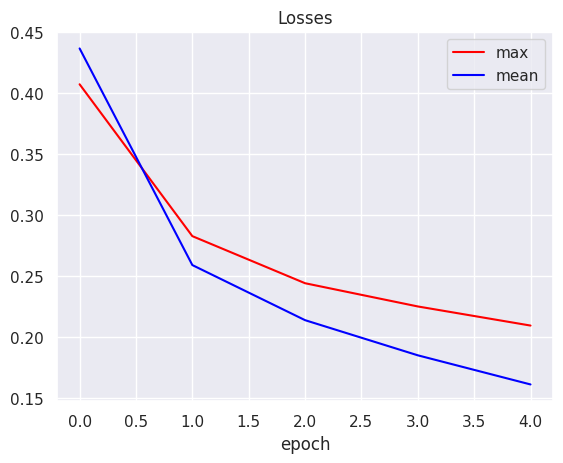

In [ ]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 90.16

Лучшая accuracy для подхода mean: 90.88


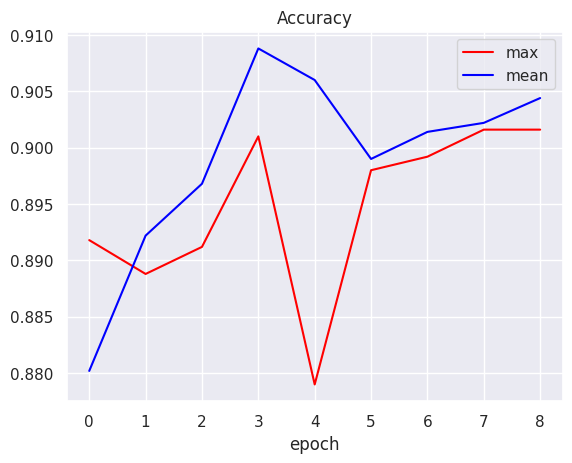

In [ ]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [ ]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

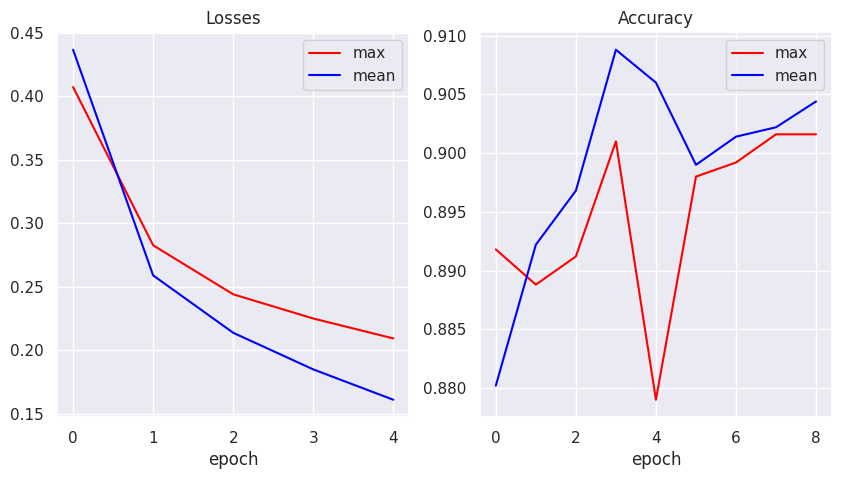

In [ ]:
plt.figure(figsize=(10, 5))

for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    # графики функции потерь
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)
    plt.legend()
    plt.title('Losses')
    plt.xlabel("epoch")


    # графики функции accuracy
    plt.subplot(1, 2, 2)
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    plt.legend()
    plt.title('Accuracy')
    plt.xlabel("epoch")

plt.show()

In [ ]:
for (name, values) in losses_type.items():
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

Лучшая accuracy для подхода max: 90.16

Лучшая accuracy для подхода mean: 90.88


Сохранение результата для сравнения

In [ ]:
compare_df1 = pd.DataFrame({'max': round(max(acc_type['max']), 3), 'mean': round(max(acc_type['mean']), 3)}, index = ['acc_base'])
compare_df1

,max,mean
acc_base,0.902,0.909


## Проведение экспериментов

In [ ]:
# Функция запуска обучения
def train_loop():
    num_epoch = 5
    eval_steps = len(train_dataloader) // 2


    losses_type = {}
    acc_type = {}

    for aggregation_type in ['max', 'mean']:
        print(f"Starting training for {aggregation_type}")
        losses = []
        acc = []

        model = CharLM(
            hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
        criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
        optimizer = torch.optim.Adam(model.parameters())

        for epoch in range(num_epoch):
            epoch_losses = []
            model.train()
            for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
                optimizer.zero_grad()
                logits = model(batch['input_ids'])
                loss = criterion(logits, batch['label'])
                loss.backward()
                optimizer.step()

                epoch_losses.append(loss.item())
                if i % eval_steps == 0:
                    model.eval()
                    acc.append(evaluate(model, eval_dataloader))
                    model.train()

            losses.append(sum(epoch_losses) / len(epoch_losses))

        losses_type[aggregation_type] = losses
        acc_type[aggregation_type] = acc
    return   losses_type , acc_type

In [ ]:
# Функция для отрисовки графиков
def plot_graph():
    plt.figure(figsize=(10, 5))

    for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
        # графики функции потерь
        plt.subplot(1, 2, 1)
        plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)
        plt.legend()
        plt.title('Losses')
        plt.xlabel("epoch")


        # графики функции accuracy
        plt.subplot(1, 2, 2)
        plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
        plt.legend()
        plt.title('Accuracy')
        plt.xlabel("epoch")

    plt.show()

    for (name, values) in losses_type.items():
        print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

### Эксперимент (1)

#### Модель GRU

Изменение рекурентного слоя с RNN на GRU

In [ ]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [ ]:
model = CharLM(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
losses_type, acc_type = train_loop()

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

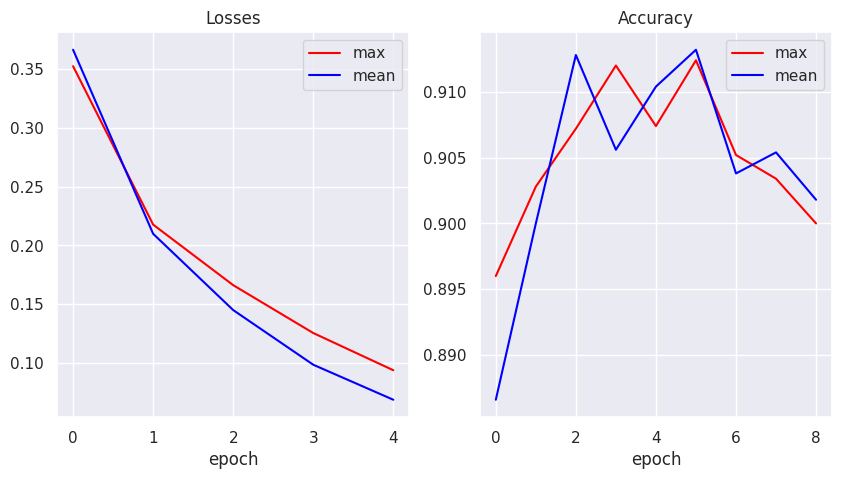

Лучшая accuracy для подхода max: 91.24

Лучшая accuracy для подхода mean: 91.32


In [ ]:
plot_graph()

In [ ]:
compare_df2 = pd.DataFrame({'max': round(max(acc_type['max']), 3), 'mean': round(max(acc_type['mean']), 3)}, index = ['acc_e2(GRU)'])
compare_df3 =  pd.concat((compare_df1, compare_df2), axis = 0)
compare_df3

,max,mean
acc_base,0.902,0.909
acc_e2(GRU),0.912,0.913


In [ ]:
compare_df = compare_df3
compare_df.to_pickle("compare_result.df", compression="gzip")

#### Bidirectional GRU

Добавление в рекурентный слой гиперпараметра Bidirectional = True

In [ ]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(hidden_dim * 2, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [ ]:
model = CharLM(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
losses_type, acc_type = train_loop()

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

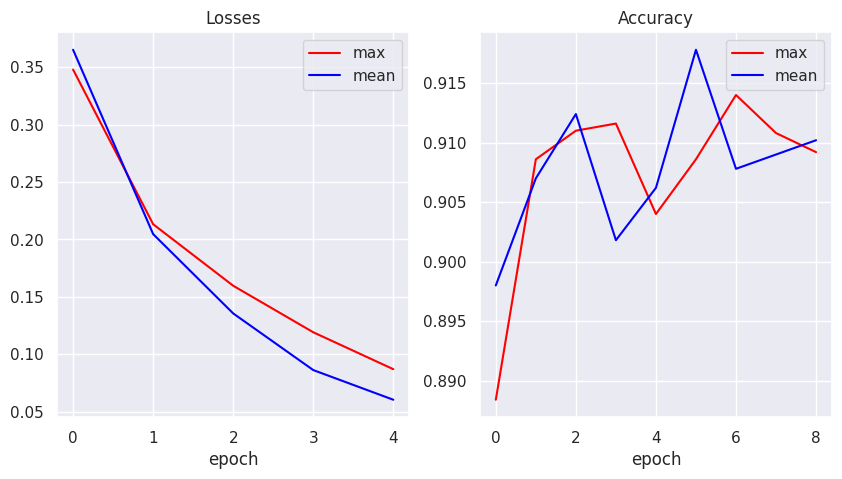

Лучшая accuracy для подхода max: 91.40

Лучшая accuracy для подхода mean: 91.78


In [ ]:
plot_graph()

In [ ]:
compare_df4 = pd.DataFrame({'max': round(max(acc_type['max']), 3), 'mean': round(max(acc_type['mean']), 3)}, index = ['acc_e3(GRU-Bidirectional)'])
compare_df5 =  pd.concat((compare_df3, compare_df4), axis = 0)
compare_df5

,max,mean
acc_base,0.902,0.909
acc_e2(GRU),0.912,0.913
acc_e3(GRU-Bidirectional),0.914,0.918


In [ ]:
compare_df = compare_df5
compare_df.to_pickle("compare_result.df", compression="gzip")

#### LSTM Bidirectional

Изменение типа рекурентного слоя с GRU  на LSTM (bidirectional=True)

In [ ]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(hidden_dim * 2, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [ ]:
model = CharLM(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
losses_type, acc_type = train_loop()

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

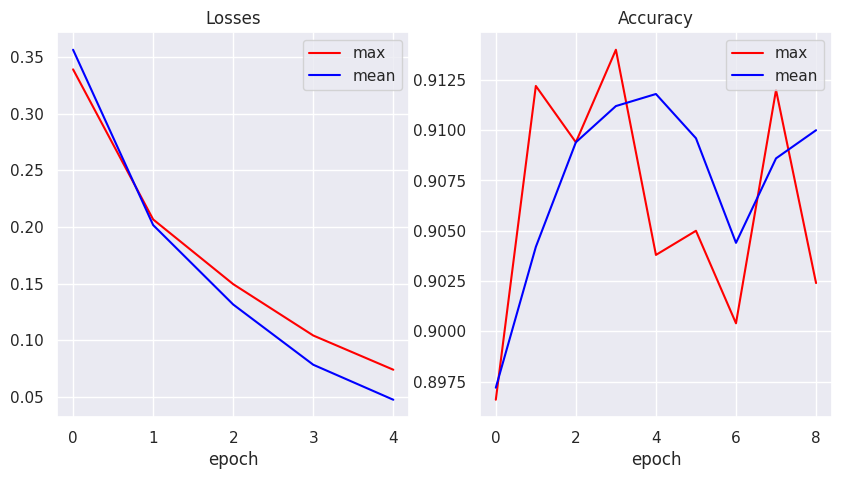

Лучшая accuracy для подхода max: 91.40

Лучшая accuracy для подхода mean: 91.18


In [ ]:
plot_graph()

In [ ]:
compare_df6 = pd.DataFrame({'max': round(max(acc_type['max']), 3), 'mean': round(max(acc_type['mean']), 3)}, index = ['acc_e3(LSTM-Bidirectional)'])
compare_df7 =  pd.concat((compare_df5, compare_df6), axis = 0)
compare_df7

,max,mean
acc_base,0.902,0.909
acc_e2(GRU),0.912,0.913
acc_e3(GRU-Bidirectional),0.914,0.918
acc_e3(LSTM-Bidirectional),0.914,0.912


In [ ]:
compare_df = compare_df7
compare_df.to_pickle("compare_result.df", compression="gzip")

### Экспермент (2)

#### num_layers=2

 Увеличение количества рекуррентных слоев модели - num_layers=2 в классе nn.RNN.

In [ ]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        num_layers = 2,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, num_layers, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(hidden_dim * 2, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [ ]:
model = CharLM(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
model

CharLM(
  (embedding): Embedding(11842, 256)
  (rnn): GRU(256, 256, num_layers=2, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=512, out_features=256, bias=True)
  (projection): Linear(in_features=256, out_features=4, bias=True)
  (non_lin): Tanh()
  (dropout): Dropout(p=0.1, inplace=False)
)

In [ ]:
losses_type, acc_type = train_loop()

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

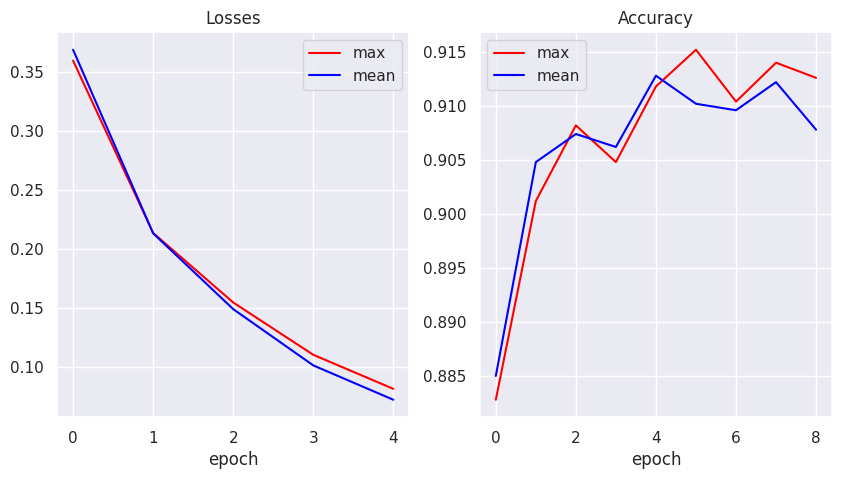

Лучшая accuracy для подхода max: 91.52

Лучшая accuracy для подхода mean: 91.28


In [ ]:
plot_graph()

In [ ]:
compare_df8 = pd.DataFrame({'max': round(max(acc_type['max']), 3), 'mean': round(max(acc_type['mean']), 3)}, index = ['acc_e4(GRU-Bi-layers=2)'])
compare_df9 =  pd.concat((compare_df7, compare_df8), axis = 0)
compare_df9

,max,mean
acc_base,0.902,0.909
acc_e2(GRU),0.912,0.913
acc_e3(GRU-Bidirectional),0.914,0.918
acc_e3(LSTM-Bidirectional),0.914,0.912
acc_e4(GRU-Bi-layers=2),0.915,0.913


In [ ]:
compare_df = compare_df9
compare_df.to_pickle("compare_result.df", compression="gzip")

### Эксперимент (3)

####  Изменение архитектуры после применения RNN

Конкатенация результата агрегации и последнего выхода скрытого слоя

In [ ]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        num_layers = 2,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, num_layers, batch_first=True)
        self.linear = nn.Linear(2*hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, h = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output_ma = output.max(dim=1)[0] #[batch_size, hidden_dim]
            out = (output_ma, h[-1])
            output = torch.cat(out, dim=1)


        elif self.aggregation_type == 'mean':
            output_me = output.mean(dim=1) #[batch_size, hidden_dim]
            out = (output_me, h[-1])
            output = torch.cat(out, dim=1)


        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]
        return prediction

In [ ]:
model = CharLM(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
losses_type, acc_type = train_loop()

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

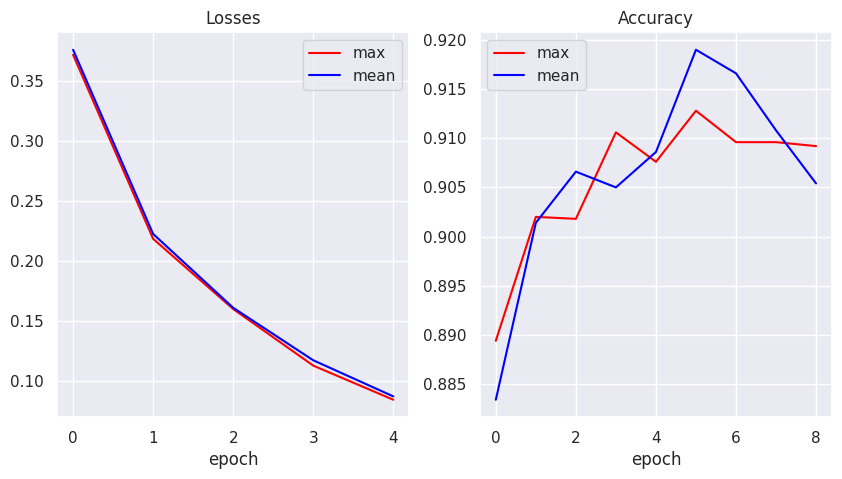

Лучшая accuracy для подхода max: 91.28
Лучшая accuracy для подхода mean: 91.90


In [ ]:
plot_graph()

In [ ]:
compare_df10 = pd.DataFrame({'max': round(max(acc_type['max']), 3), 'mean': round(max(acc_type['mean']), 3)}, index = ['acc_e4(GRU-concat)'])
compare_df11 =  pd.concat((compare_df9, compare_df10), axis = 0)
compare_df11

,max,mean
acc_base,0.902,0.909
acc_e2(GRU),0.912,0.913
acc_e3(GRU-Bidirectional),0.914,0.918
acc_e3(LSTM-Bidirectional),0.914,0.912
acc_e4(GRU-Bi-layers=2),0.915,0.913
acc_e4(GRU-concat),0.913,0.919


In [ ]:
compare_df = compare_df11
compare_df.to_pickle("compare_result.df", compression="gzip")

### Эксперимент (4)

#### hidden_dim = 512

Конкатенация результата агрегации и последнего выхода скрытого слоя + hidden_dim=512

In [ ]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(hidden_dim * 2, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [ ]:
model = CharLM(hidden_dim=512, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
losses_type, acc_type = train_loop()

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

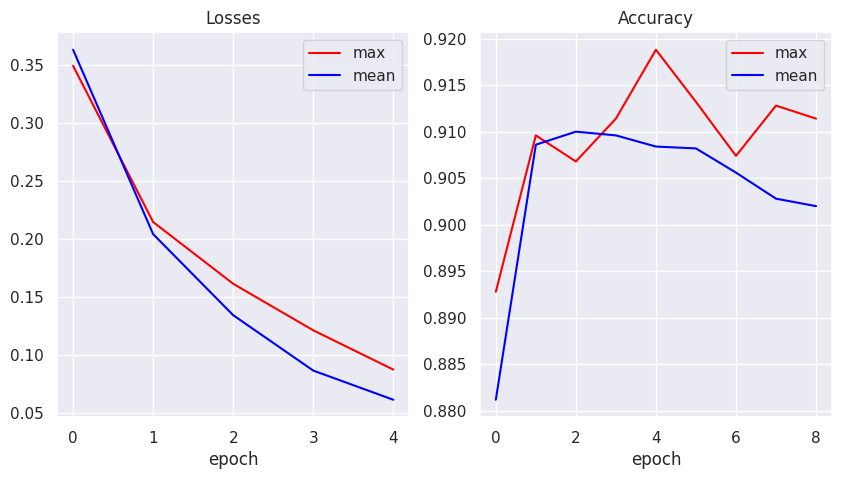

Лучшая accuracy для подхода max: 91.88
Лучшая accuracy для подхода mean: 91.00


In [ ]:
plot_graph()

In [ ]:
compare_df12 = pd.DataFrame({'max': round(max(acc_type['max']), 3), 'mean': round(max(acc_type['mean']), 3)}, index = ['acc_e5(GRU-concat-hd_512)'])
compare_df13 =  pd.concat((compare_df11, compare_df12), axis = 0)
compare_df13

,max,mean
acc_base,0.902,0.909
acc_e2(GRU),0.912,0.913
acc_e3(GRU-Bidirectional),0.914,0.918
acc_e3(LSTM-Bidirectional),0.914,0.912
acc_e4(GRU-Bi-layers=2),0.915,0.913
acc_e4(GRU-concat),0.913,0.919
acc_e5(GRU-concat-hd_512),0.919,0.910


In [ ]:
compare_df = compare_df13
compare_df.to_pickle("compare_result.df", compression="gzip")

#### Изменение batch_size = 64

In [ ]:
train_dataset = WordDataset(dataset['train'])

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 5000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 64
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

In [ ]:
model = CharLM(hidden_dim=512, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
losses_type, acc_type = train_loop()

Starting training for max


Training epoch 0::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/1875 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/1875 [00:00<?, ?it/s]

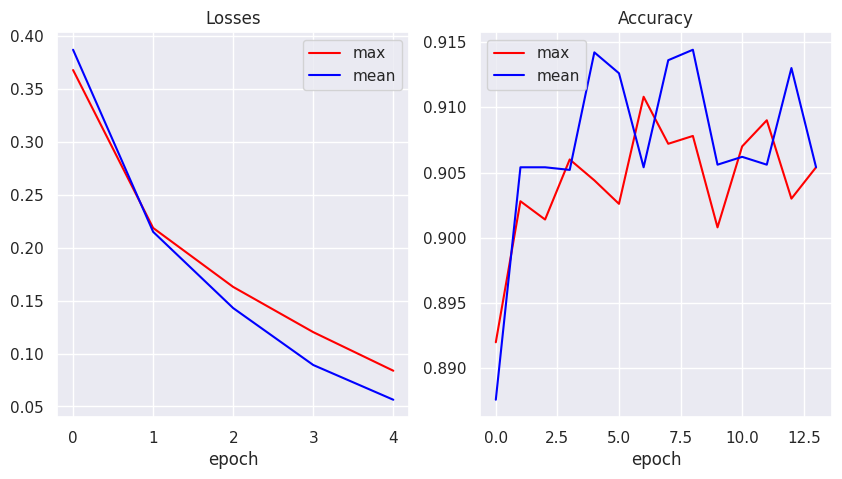

Лучшая accuracy для подхода max: 91.08
Лучшая accuracy для подхода mean: 91.44


In [ ]:
plot_graph()

In [ ]:
compare_df14 = pd.DataFrame({'max': round(max(acc_type['max']), 3), 'mean': round(max(acc_type['mean']), 3)}, index = ['acc_e5(GRU-concat-hd_512-bs=64)'])
compare_df15 =  pd.concat((compare_df13, compare_df14), axis = 0)
compare_df15

,max,mean
acc_base,0.902,0.909
acc_e2(GRU),0.912,0.913
acc_e3(GRU-Bidirectional),0.914,0.918
acc_e3(LSTM-Bidirectional),0.914,0.912
acc_e4(GRU-Bi-layers=2),0.915,0.913
acc_e4(GRU-concat),0.913,0.919
acc_e5(GRU-concat-hd_512),0.919,0.910
acc_e5(GRU-concat-hd_512-bs=64),0.911,0.914


In [ ]:
compare_df = compare_df15
compare_df.to_pickle("compare_result.df", compression="gzip")


#### Увеличение dropout = 0.25

In [ ]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        num_layers = 2,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, num_layers, dropout = 0.25, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(hidden_dim * 2, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.25)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [ ]:
model = CharLM(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
losses_type, acc_type = train_loop()

Starting training for max


Training epoch 0::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/1875 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/1875 [00:00<?, ?it/s]

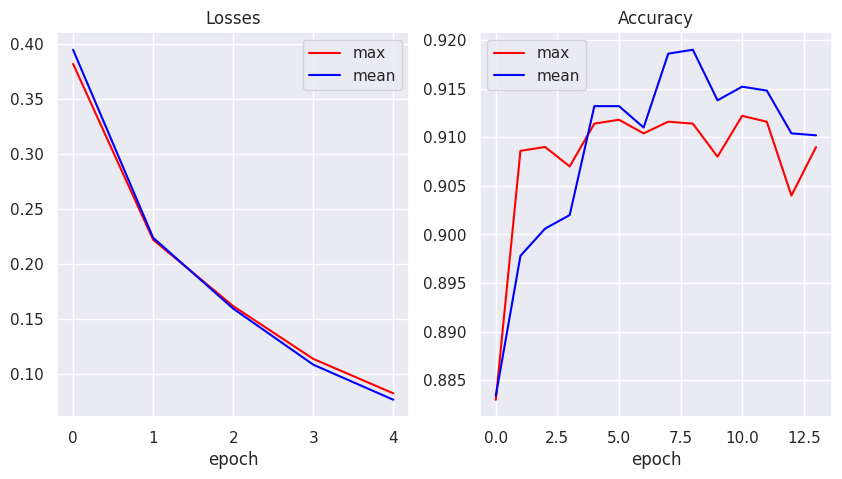

Лучшая accuracy для подхода max: 91.22
Лучшая accuracy для подхода mean: 91.90


In [ ]:
plot_graph()

In [ ]:
compare_df16 = pd.DataFrame({'max': round(max(acc_type['max']), 3), 'mean': round(max(acc_type['mean']), 3)}, index = ['acc_e6(GRU-Bi-bs=64-dp_0.25)'])
compare_df17 =  pd.concat((compare_df15, compare_df16), axis = 0)
compare_df17

,max,mean
acc_base,0.902,0.909
acc_e2(GRU),0.912,0.913
acc_e3(GRU-Bidirectional),0.914,0.918
acc_e3(LSTM-Bidirectional),0.914,0.912
acc_e4(GRU-Bi-layers=2),0.915,0.913
acc_e4(GRU-concat),0.913,0.919
acc_e5(GRU-concat-hd_512),0.919,0.910
acc_e5(GRU-concat-hd_512-bs=64),0.911,0.914
acc_e6(GRU-Bi-bs=64-dp_0.25),0.912,0.919


In [ ]:
compare_df = compare_df17
compare_df.to_pickle("compare_result.df", compression="gzip")

#### Изменение learning rate с помошью lr_scheduler.MultiStepLR

In [ ]:
model = CharLM(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[7], gamma=0.5)

In [ ]:
scheduler

In [ ]:
num_epoch = 10
eval_steps = len(train_dataloader) // 2


losses_type = {}
acc_type = {}
lr_value = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []
    lr_val = []

    for epoch in range(num_epoch):
        epoch_losses = []

        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])

            loss.backward()
            optimizer.step()


            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate(model, eval_dataloader))
                model.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))
        lr_val.append(optimizer.state_dict()['param_groups'][0]['lr'])


        scheduler.step()

    lr_value[aggregation_type] = lr_val
    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

Starting training for max


Training epoch 0::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/1875 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/1875 [00:00<?, ?it/s]

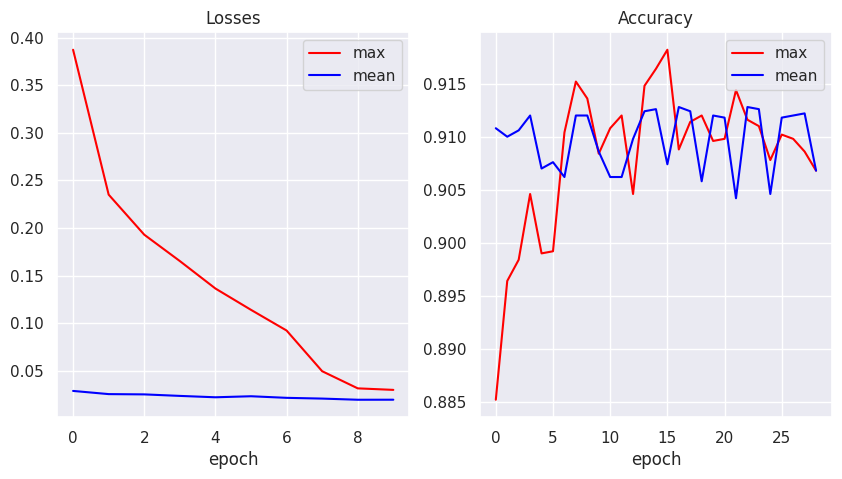

Лучшая accuracy для подхода max: 91.82
Лучшая accuracy для подхода mean: 91.28


In [ ]:
plot_graph()

In [ ]:
compare_df18 = pd.DataFrame({'max': round(max(acc_type['max']), 3), 'mean': round(max(acc_type['mean']), 3)}, index = ['acc_e6(GRU-Bi-bs=64-dp_0.25_lr_ep_10)'])
compare_df19 = pd.concat((compare_df17, compare_df18), axis = 0)
compare_df19

,max,mean
acc_base,0.902,0.909
acc_e2(GRU),0.912,0.913
acc_e3(GRU-Bidirectional),0.914,0.918
acc_e3(LSTM-Bidirectional),0.914,0.912
acc_e4(GRU-Bi-layers=2),0.915,0.913
acc_e4(GRU-concat),0.913,0.919
acc_e5(GRU-concat-hd_512),0.919,0.910
acc_e5(GRU-concat-hd_512-bs=64),0.911,0.914
acc_e6(GRU-Bi-bs=64-dp_0.25),0.912,0.919
acc_e6(GRU-Bi-bs=64-dp_0.25_lr_ep_10),0.918,0.913


In [ ]:
compare_df = compare_df19
compare_df.to_pickle("compare_result.df", compression="gzip")

Динамическое изменение learning_rate во время обучения не привнесло дополнительного приемущества.

### Выводы и сводные результаты

In [ ]:
compare_df

,max,mean
acc_base,0.902,0.909
acc_e2(GRU),0.912,0.913
acc_e3(GRU-Bidirectional),0.914,0.918
acc_e3(LSTM-Bidirectional),0.914,0.912
acc_e4(GRU-Bi-layers=2),0.915,0.913
acc_e4(GRU-concat),0.913,0.919
acc_e5(GRU-concat-hd_512),0.919,0.910
acc_e5(GRU-concat-hd_512-bs=64),0.911,0.914
acc_e6(GRU-Bi-bs=64-dp_0.25),0.912,0.919
acc_e6(GRU-Bi-bs=64-dp_0.25_lr_ep_10),0.918,0.913


В ходе изменения гиперпараметров максимальная accuracy получилась 91,9%.
С базовыми параметрами получилось самое низкое качество.
В сравнительной таблице видно, что при изменении параметров обучения качество в 91,9% получилось при следующих архитектурах:
* GRU + агрегация эмбеддингов с усреднением сконкотенированная с последним скрытым слоем (hidden_dim = 256)
* GRU + агрегация эмбеддингов по максимуму сконкотенированная с последним скрытым слоем (hidden_dim = 512)
* Bidirectional GRU с размерам батча 64, добавлением dropout = 0.25 в слой RNN плюс отдельный dropout слой = 0.25